In [1]:
from pathlib import Path
from ray.train import Checkpoint
from my_chess.learner.models import DeepChessFE, DeepChessFEConfig
from my_chess.learner.datasets import ChessData
from my_chess.learner.algorithms import Trainable, TrainableConfig, AutoEncoder, collate_wrapper
from torch.utils.data import DataLoader, random_split
import torch
import pickle
from os import path
import chess
import pettingzoo.classic.chess
import pygame
import numpy as np
import matplotlib.pyplot as plt
from my_chess.learner.datasets.chess import env

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
def get_setup(cps, sample_size=5):
    encs = []
    decs = []
    samples = None
    inp_sample = None
    trainset = None
    valset = None
    for i, cp in enumerate(cps):
        cp = Path(cp)
        x = None
        with open(cp/"params.pkl",'rb') as f:
            x = pickle.load(f)
        
        if i == 0:
            dataset = x['dataset'](**x['dataset_config'])
            gen = torch.Generator().manual_seed(x['seed'])
            trainset, valset, testset = random_split(dataset, x['data_split'], generator=gen)
            if not x['shuffle']:
                # Improves data gathering speeds. Selected indices for each set are still random.
                trainset.indices = sorted(trainset.indices)
                valset.indices = sorted(valset.indices)
                testset.indices = sorted(testset.indices)
            dl_kwargs = dict(
                batch_size=1,
                shuffle=x['shuffle'],
                collate_fn=collate_wrapper,
                pin_memory=x['pin_memory'],
                num_workers=0,
                # prefetch_factor=1
                )
            trainloader = DataLoader(trainset, **dl_kwargs)
            valloader = DataLoader(valset, **dl_kwargs)
            testloader = DataLoader(testset, **dl_kwargs)
            inp_sample = next(iter(trainloader)).inp

        enc = x['model'](input_sample=inp_sample, config=x['model_config'])
        dec = AutoEncoder.create_decoder(enc, inp_sample)

        latest_checkpoint = sorted(cp.glob('checkpoint*'), reverse=True)[0]

        enc.load_state_dict(torch.load(latest_checkpoint/'model.pt'))
        dec.load_state_dict(torch.load(latest_checkpoint/'model_decoder.pt'))
        
        encs.append(enc)
        decs.append(dec)

    rng = np.random.default_rng()
    train_idxs = rng.integers(len(trainset), size=sample_size)
    train_samples = [trainset[i][0][None,:].to(next(iter(enc.parameters())).dtype) for i in train_idxs]
    val_idxs = rng.integers(len(valset), size=sample_size)
    val_samples = [valset[i][0][None,:].to(next(iter(enc.parameters())).dtype) for i in val_idxs]

    return {
        'encs':encs,
        'decs':decs,
        'train_samples':train_samples,
        'val_samples':val_samples,
    }

In [4]:
class Renderer:
    def __init__(self, render_mode:str='rgb_array', screen_height = 250) -> None:
        self.screen = None
        self.render_mode = render_mode
        self.screen_width = self.screen_height = screen_height
        if self.render_mode in ["human", "rgb_array"]:
            self.BOARD_SIZE = (self.screen_width, self.screen_height)
            self.clock = pygame.time.Clock()
            self.cell_size = (self.BOARD_SIZE[0] / 8, self.BOARD_SIZE[1] / 8)
            bg_name = path.join(path.dirname(pettingzoo.classic.chess.__file__), "img/chessboard.png")
            self.bg_image = pygame.transform.scale(
                pygame.image.load(bg_name), self.BOARD_SIZE
            )

            def load_piece(file_name):
                img_path = path.join(path.dirname(pettingzoo.classic.chess.__file__), f"img/{file_name}.png")
                return pygame.transform.scale(
                    pygame.image.load(img_path), self.cell_size
                )

            self.piece_images = {
                "pawn": [load_piece("pawn_black"), load_piece("pawn_white")],
                "knight": [load_piece("knight_black"), load_piece("knight_white")],
                "bishop": [load_piece("bishop_black"), load_piece("bishop_white")],
                "rook": [load_piece("rook_black"), load_piece("rook_white")],
                "queen": [load_piece("queen_black"), load_piece("queen_white")],
                "king": [load_piece("king_black"), load_piece("king_white")],
            }

    def render(self, board):
        if self.screen is None:
            pygame.init()

            if self.render_mode == "human":
                pygame.display.set_caption("Chess")
                self.screen = pygame.display.set_mode(self.BOARD_SIZE)
            elif self.render_mode == "rgb_array":
                self.screen = pygame.Surface(self.BOARD_SIZE)

        self.screen.blit(self.bg_image, (0, 0))
        for square, piece in board.piece_map().items():
            pos_x = square % 8 * self.cell_size[0]
            pos_y = (
                self.BOARD_SIZE[1] - (square // 8 + 1) * self.cell_size[1]
            )  # offset because pygame display is flipped
            piece_name = chess.piece_name(piece.piece_type)
            piece_img = self.piece_images[piece_name][piece.color]
            self.screen.blit(piece_img, (pos_x, pos_y))

        if self.render_mode == "human":
            pygame.display.update()
            # self.clock.tick(self.metadata["render_fps"])
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

In [5]:
def board_samples(samples, encs, decs):
    chess_env = env()
    fig, axs = plt.subplots(
        len(encs)+1,
        len(samples),
        # sharex='col',
        # sharey='row',
        # layout='constrained',
        squeeze=False,
        gridspec_kw=dict(hspace=0.1, wspace=0.1),
        subplot_kw={'xticks': [], 'yticks': []}
        )

    ren = Renderer()
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            if i == 0:
                fen_in = chess_env.observation_to_fen(samples[j])
                chess_env.board.set_fen(fen_in[0])
                ax.imshow(ren.render(chess_env.board))
                if j == 0:
                    ax.set_ylabel('input', rotation='horizontal', ha='right', va='center')
            else:
                enc = encs[i-1]
                dec = decs[i-1]
                out = dec(enc(samples[j]))
                fen_out = chess_env.observation_to_fen(out)
                chess_env.board.set_fen(fen_out[0])
                ax.imshow(ren.render(chess_env.board))
                if j == 0:
                    ax.set_ylabel('Model Shape:\n{}'.format(',\n'.join(map(str, enc.config.hidden_dims))), rotation='horizontal', ha='right', va='center')
    # for ax in fig.get_axes():
    #     ax.label_outer()
    # fig.suptitle('Model Shape:\n{}'.format(enc.config.hidden_dims))
    # fig.tight_layout()
    plt.show()


In [6]:
setup = get_setup([
    # './results/ChessFeatureExtractor/AutoEncoder_f60ac_00000_0_batch_size=256,model_config=ref_ph_a52f5213,lr=0.0000_2024-03-04_15-28-52/',
    # './results/ChessFeatureExtractor/AutoEncoder_8e326_00001_1_batch_size=256,model_config=ref_ph_4aa0e992,lr=0.0001_2024-02-27_15-47-24/',
    # './results/ChessFeatureExtractor/AutoEncoder_8e326_00002_2_batch_size=256,model_config=ref_ph_ffdfbe01,lr=0.0001_2024-02-27_15-47-24/',
    # './results/ChessFeatureExtractor/AutoEncoder_8e326_00003_3_batch_size=256,model_config=ref_ph_46c7d52d,lr=0.0001_2024-02-27_15-47-24/',
    './results/ChessFeatureExtractor/AutoEncoder_8e326_00004_4_batch_size=256,model_config=ref_ph_d2c2b490,lr=0.0001_2024-02-27_15-47-24/',
    # './results/ChessFeatureExtractor/AutoEncoder_8e326_00005_5_batch_size=256,model_config=ref_ph_b58ba7d4,lr=0.0001_2024-02-27_15-47-24/',
    # './results/ChessFeatureExtractor/AutoEncoder_82879_00001_1_batch_size=256,learning_rate_scheduler_config=step_size_25,model_config=ref_ph_a52f5213,lr=0.0001_2024-03-05_00-15-21/',
    './results/ChessFeatureExtractor/AutoEncoder_5a829_00000_0_batch_size=256,model_config=ref_ph_a52f5213,lr=0.0001_2024-03-07_00-47-39/',
    ])

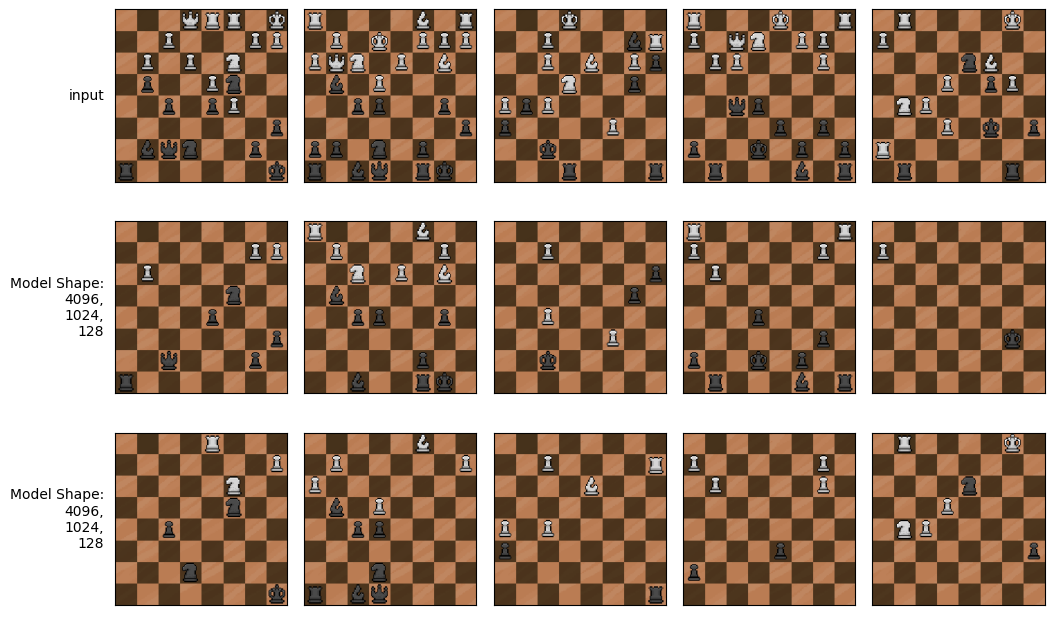

In [12]:
board_samples(setup['train_samples'], setup['encs'], setup['decs'])

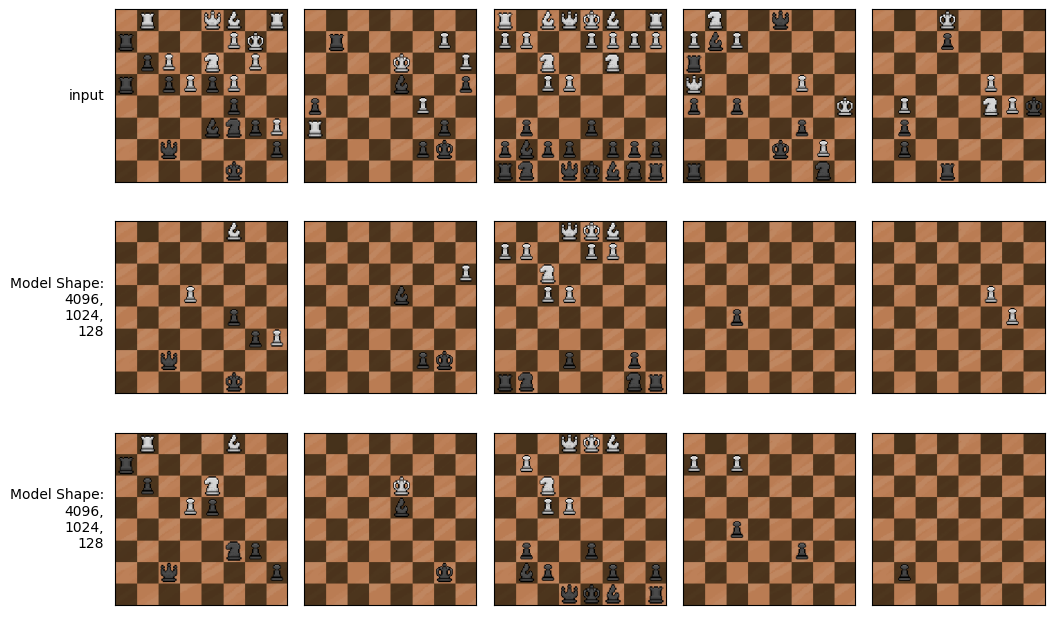

: 

In [13]:
board_samples(setup['val_samples'], setup['encs'], setup['decs'])